# Library

In [75]:
import numpy as np
import matplotlib.pyplot as plt

import skfuzzy as fuzz
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import pandas as pd
import geopandas as gpd
from matplotlib import colors
from matplotlib import cm
import sys, os

# Syntax FCM

In [76]:
np.random.seed(42)

# Menghitung Pusat Cluster (V)
def calculate_centers(data, U, m):
    np.random.seed(42)
    um = U ** m
    #um = np.fmax(um, np.finfo(np.float64).eps)
    centers = np.dot(um.T, data) / np.sum(um, axis=0, keepdims=True).T
    #centers = np.fmax(centers, np.finfo(np.float64).eps)
    return centers


# Menghitung Matriks Keanggotaan Fuzzy (U)
def update_membership(data, centers, m):
    np.random.seed(42)
    distance_matrix = np.linalg.norm(data[:, np.newaxis] - centers, axis=2) ** (2/(m-1))
    distance_matrix = np.fmax(distance_matrix, np.finfo(np.float64).eps)
    print("\nmatriks jarak")
    print(np.linalg.norm(data[:, np.newaxis] - centers, axis=2))
    um = 1.0 / distance_matrix
    um = np.fmax(um, np.finfo(np.float64).eps)
    u_new = um / np.sum(um, axis=1, keepdims=True)
    u_new = np.fmax(u_new, np.finfo(np.float64).eps)
    return u_new

def fuzzy_c_means(data, n_clusters, m, max_iters, tol):
    np.random.seed(42)
    n_samples, n_features = data.shape

    # Inisialisasi nilai keanggotaan fuzzy secara acak
    
    U = np.random.rand(n_samples, n_clusters)
    U /= np.sum(U, axis=1, keepdims=True)
    print("Matriks Fuzzy Awal")
    print(U, "\n")
    
    for iteration in range(max_iters):
        print("\n","*"*20)
        print("Iterasi Ke-",iteration)
        
        # Simpan nilai keanggotaan fuzzy sebelum diperbarui
        U_old = U.copy()

        # Langkah 1: Perbarui pusat klaster
        centers = calculate_centers(data, U, m)
        print("\nPusat Cluster Iterasi Ke-", iteration)
        print(centers)

        # Langkah 2: Perbarui nilai keanggotaan fuzzy
        U = update_membership(data, centers, m)
        print("\nMatriks Fuzzy Terperbarui pada iterasi Ke-", iteration)
        print(U)

        # Hitung perubahan nilai keanggotaan fuzzy
        diff = np.linalg.norm(U - U_old)
        print("\nNilai U baru - U Sekarang =", diff)
        
        # Cek kriteria konvergensi
        if diff < tol:
            # print("Konvergensi tercapai pada iterasi ke-{}".format(iteration + 1))
            break

    return U, centers

# Aplikasi FCM pada data yang dianalisis

In [77]:
# Import Data
df = pd.read_csv("data kemiskinan.csv", sep = ";")
df

,ADM2_EN,PPM,IPM,UHH,HLS,RLS,DTKS
0,Bantaeng,9.07,69.69,70.88,12.30,6.81,117414
1,Barru,8.40,71.53,69.35,13.61,8.25,89034
2,Bone,10.58,67.01,67.57,12.99,7.36,597850
3,Bulukumba,7.39,70.34,68.51,13.42,8.01,181002
4,Enrekang,12.39,73.39,71.17,13.86,8.93,162947
5,Gowa,7.36,70.99,70.70,13.66,8.40,404024
6,Jeneponto,13.73,65.13,66.81,12.11,6.75,285279
7,Kepulauan Selayar,12.24,68.35,68.81,12.67,8.09,75526
8,Kota Makassar,4.58,83.12,72.40,15.59,11.55,436869
9,Kota Palopo,7.78,78.91,71.18,15.10,11.09,105371


In [78]:
# Deskripsi Data
df.describe()

,PPM,IPM,UHH,HLS,RLS,DTKS
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,9.318333,71.435417,69.889167,13.360833,8.360417,205783.666667
std,2.830432,3.945276,1.938076,0.816775,1.196210,123188.871138
min,4.580000,65.130000,66.810000,12.110000,6.750000,64437.000000
25%,7.382500,69.697500,68.337500,12.937500,7.850000,136987.000000
50%,8.795000,70.435000,70.175000,13.275000,8.045000,174475.000000
75%,12.195000,71.992500,70.997500,13.622500,8.490000,222295.500000
max,13.920000,83.120000,73.720000,15.590000,11.550000,597850.000000


In [79]:
# Mengubah Data agar Bisa diolah
data = df.iloc[:, 1:]
data = data.values
np.set_printoptions(suppress=True)

# # Membuat objek MinMaxScaler
# scaler = MinMaxScaler()
# # Melakukan normalisasi dengan Min-Max Scaling
# normalized_data = scaler.fit_transform(data)
# normalized_data

# # Z-Score Normalization
# mean = np.mean(data, axis=0)
# std_dev = np.std(data, axis=0)
# normalized_data = (data - mean) / std_dev
# normalized_data

# # Membuat objek StandardScaler
# scaler = StandardScaler()
# # Melakukan standarisasi
# normalized_data = scaler.fit_transform(data)
# normalized_data

In [80]:
data

array([[     9.07,     69.69,     70.88,     12.3 ,      6.81, 117414.  ],
       [     8.4 ,     71.53,     69.35,     13.61,      8.25,  89034.  ],
       [    10.58,     67.01,     67.57,     12.99,      7.36, 597850.  ],
       [     7.39,     70.34,     68.51,     13.42,      8.01, 181002.  ],
       [    12.39,     73.39,     71.17,     13.86,      8.93, 162947.  ],
       [     7.36,     70.99,     70.7 ,     13.66,      8.4 , 404024.  ],
       [    13.73,     65.13,     66.81,     12.11,      6.75, 285279.  ],
       [    12.24,     68.35,     68.81,     12.67,      8.09,  75526.  ],
       [     4.58,     83.12,     72.4 ,     15.59,     11.55, 436869.  ],
       [     7.78,     78.91,     71.18,     15.1 ,     11.09, 105371.  ],
       [     5.41,     78.54,     71.57,     14.52,     10.66,  64437.  ],
       [    12.49,     71.36,     70.75,     13.4 ,      8.48, 275207.  ],
       [     6.81,     73.92,     70.94,     13.  ,      8.92, 167948.  ],
       [    13.22,     70

### Penentuan Kluster terbaik FCM Pada Data Penelitian

In [81]:
list_n_clusters = [2,3,4,5,6,7,8,9,10]
m = 2

# Membuat DataFrame kosong dengan nama kolom
columns = ['n_cluster',  'calinski_harabasz_avg']
df_fuzzy_c_means = pd.DataFrame(columns=columns)

sys._original_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

for n_clusters in list_n_clusters:
    max_iters = 100
    tol = 1e-3

    U, centers = fuzzy_c_means(data, n_clusters, m, max_iters, tol)

    class_cluster_list = []
    for i in U:
        class_cluster_list.append(np.argmax(i))

    # Menghitung Silhouette Score
    silhouette_avg = silhouette_score(data, class_cluster_list)
    davies_bouldin_avg = davies_bouldin_score(data, class_cluster_list)
    calinski_harabasz_avg = calinski_harabasz_score(data, class_cluster_list)
        
    # Menambahkan baris baru dengan list
    new_row = [n_clusters, calinski_harabasz_avg]  # Ganti dengan nilai yang sesuai
    df_fuzzy_c_means.loc[len(df_fuzzy_c_means)] = new_row


sys.stdout.close()
sys.stdout = sys._original_stdout

    
df_fuzzy_c_means

,n_cluster,calinski_harabasz_avg
0,2.0,61.452842
1,3.0,66.483378
2,4.0,78.769601
3,5.0,136.755365
4,6.0,225.042095
5,7.0,306.964097
6,8.0,32.333977
7,9.0,286.846541
8,10.0,282.401463


In [82]:
# Mengurutkan berdasarkan kolom 'kinerja' secara naik
df_sorted = df_fuzzy_c_means.sort_values(by='calinski_harabasz_avg', ascending=False)
df_sorted

,n_cluster,calinski_harabasz_avg
5,7.0,306.964097
7,9.0,286.846541
8,10.0,282.401463
4,6.0,225.042095
3,5.0,136.755365
2,4.0,78.769601
1,3.0,66.483378
0,2.0,61.452842
6,8.0,32.333977


In [83]:
#df_fuzzy_c_means.to_csv("df_fuzzy_c_means_daus.csv", index=False)

## Peta Clustering FCM

In [84]:
n_clusters = 7
m = 2
max_iters = 100
tol = 1e-3

U, centers = fuzzy_c_means(data, n_clusters, m, max_iters, tol)


class_cluster_list = []
for i in U:
    class_cluster_list.append(np.argmax(i))

print("Nilai keanggotaan fuzzy:")
print(U)
print("Penentuan Kelas")
print(class_cluster_list)
print("Pusat klaster:")
print(centers)

# Menghitung Silhouette Score
silhouette_avg = silhouette_score(data, class_cluster_list)
davies_bouldin_avg = davies_bouldin_score(data, class_cluster_list)
calinski_harabasz_avg = calinski_harabasz_score(data, class_cluster_list)
print("davies_bouldin_score", davies_bouldin_avg)
print("Silhouette Score:", silhouette_avg)
print("calinski_harabasz_avg", calinski_harabasz_avg)

Matriks Fuzzy Awal
[[0.12377385 0.31418148 0.24190121 0.19783799 0.0515593  0.05155133
  0.01919483]
 [0.20571129 0.14276097 0.1681627  0.00488869 0.23034738 0.1976998
  0.05042918]
 [0.07188874 0.07251325 0.12028926 0.20747469 0.17077953 0.11514423
  0.2419103 ]
 [0.05066692 0.1061127  0.13306984 0.16565361 0.28519139 0.07252545
  0.18678009]
 [0.17441897 0.01367595 0.17887363 0.05020579 0.01915252 0.27937131
  0.28430182]
 [0.27382101 0.10317902 0.03308358 0.23176397 0.14908881 0.04133689
  0.16772673]
 [0.01060229 0.28035155 0.07978416 0.2042615  0.09610329 0.16034158
  0.16855563]
 [0.03498598 0.18350582 0.14670342 0.17781173 0.16935708 0.11315993
  0.17447604]
 [0.0412784  0.09141858 0.02109682 0.15175427 0.18130323 0.12657404
  0.38657465]
 [0.11201248 0.08820708 0.1703943  0.04424702 0.25187171 0.02340722
  0.30986019]
 [0.19310566 0.04969036 0.00138085 0.20391232 0.17675504 0.18229377
  0.192862  ]
 [0.03048062 0.14756307 0.04769771 0.3552981  0.25658181 0.13621478
  0.02616391

   11065.79908526  45478.59884174 259338.47852754]]

Matriks Fuzzy Terperbarui pada iterasi Ke- 17
[[0.03081816 0.77594734 0.09858638 0.00540306 0.01451427 0.073504
  0.00122678]
 [0.01065642 0.05745872 0.90342193 0.00269872 0.00606931 0.01897701
  0.00071789]
 [0.06213498 0.04813178 0.03881728 0.10648758 0.07305435 0.05530462
  0.61606942]
 [0.85739685 0.0135786  0.00318014 0.00314509 0.02298358 0.09930749
  0.00040826]
 [0.00016431 0.00009712 0.00001357 0.0000066  0.0000307  0.99968666
  0.00000105]
 [0.05205705 0.03289569 0.02306542 0.1703927  0.07159314 0.04198069
  0.60801531]
 [0.00011938 0.0000484  0.00002679 0.99943203 0.00026256 0.00007627
  0.00003457]
 [0.00064328 0.0025784  0.99509428 0.00018439 0.00038912 0.00105824
  0.00005228]
 [0.01358988 0.00907057 0.00658836 0.03633317 0.01786848 0.01125953
  0.90529   ]
 [0.04354494 0.4331731  0.40035515 0.00912848 0.0225403  0.08903114
  0.00222689]
 [0.01180549 0.03979254 0.91771584 0.00368682 0.00743654 0.01846643
  0.00109635]
 

  0.00119861]]

Nilai U baru - U Sekarang = 0.009620513789911437

 ********************
Iterasi Ke- 34

Pusat Cluster Iterasi Ke- 34
[[     8.54925011     71.10135148     69.31917433     13.30422011
       8.00939413 187084.62760569]
 [     7.92903294     70.23128678     69.7669589      13.12999961
       7.89255978 130917.13284644]
 [     8.82383593     72.91088235     69.93128506     13.62890883
       9.06827946  78193.41242555]
 [    12.99290695     68.15584871     68.71375814     12.74546896
       7.59066914 284902.10942347]
 [    11.30480862     69.86718479     68.01035688     12.75749897
       7.75471304 219060.46177776]
 [    10.75812439     71.82582719     72.32368022     13.5522217
       8.63570189 162543.33157117]
 [     6.92902322     75.87193683     70.61753508     14.42580787
       9.66585203 478222.35384803]]

matriks jarak
[[ 69670.62765697  13503.13302027  39220.58780647 167488.10949286
  101646.46184841  45129.33173068 360808.353925  ]
 [ 98050.62760751  41883.132

[[0.02943975 0.78726754 0.09308105 0.00505282 0.0138228  0.07030699
  0.00102906]
 [0.01100207 0.06044918 0.89929832 0.00273687 0.00625214 0.01960412
  0.00065731]
 [0.04795996 0.03709652 0.02995064 0.08307273 0.05642301 0.04268798
  0.70280916]
 [0.86130028 0.01309974 0.00310954 0.00299261 0.02249718 0.0966576
  0.00034306]
 [0.00025577 0.0001463  0.0000209  0.00000995 0.00004742 0.99951826
  0.0000014 ]
 [0.07194651 0.04535242 0.03186248 0.24210562 0.09906633 0.05802251
  0.45164412]
 [0.00002989 0.00001207 0.00000671 0.99985949 0.00006593 0.0000191
  0.00000682]
 [0.00056184 0.00228386 0.99569139 0.00015839 0.00033918 0.00092468
  0.00004066]
 [0.03490955 0.02324889 0.01691617 0.0953849  0.04594807 0.02892412
  0.75466831]
 [0.04323506 0.44380833 0.39132275 0.00888698 0.02232075 0.08847598
  0.00195015]
 [0.01152304 0.0392947  0.91940724 0.00354235 0.00724539 0.01803126
  0.00095602]
 [0.01357267 0.0050507  0.00270917 0.93454828 0.03356367 0.00828801
  0.0022675 ]
 [0.07030253 0.018

[[     8.5780224      70.9459311      69.1825245      13.26284176
       7.95812592 191440.81562306]
 [     7.86147437     70.20373419     69.72495366     13.13018019
       7.89162162 132034.7575564 ]
 [     8.80958537     72.94960414     69.93965614     13.64001463
       9.07647923  78654.86976519]
 [    11.24699007     69.61000504     69.08278614     13.07812616
       7.97822592 321648.39196525]
 [    12.28366771     70.07429399     68.11528975     12.76159498
       7.88448564 225102.98017913]
 [    10.65895844     71.88317026     72.25203601     13.54523894
       8.64407959 163470.03551513]
 [    10.15091925     68.08876524     67.92421718     13.16450866
       7.64064502 584603.19107249]]

matriks jarak
[[ 74026.81566998  14620.75772458  38759.13047359 204234.3919896
  107688.98026961  46056.03566855 467189.19108737]
 [102406.81562602  43000.75758603  10379.13038968 232614.39199152
  136068.98025108  74436.03560788 495569.19109015]
 [406409.18440466 465815.24246779 519195.130

davies_bouldin_score 0.33907012303590645
Silhouette Score: 0.5564238077734626
calinski_harabasz_avg 306.96409673215703


# Gambar Peta

In [85]:
df['kluster'] = class_cluster_list
for i in range(n_clusters):
    df['kluster'].replace(i, "kluster {}".format(i+1), inplace=True)
df

,ADM2_EN,PPM,IPM,UHH,HLS,RLS,DTKS,kluster
0,Bantaeng,9.07,69.69,70.88,12.30,6.81,117414,kluster 2
1,Barru,8.40,71.53,69.35,13.61,8.25,89034,kluster 3
2,Bone,10.58,67.01,67.57,12.99,7.36,597850,kluster 7
3,Bulukumba,7.39,70.34,68.51,13.42,8.01,181002,kluster 6
4,Enrekang,12.39,73.39,71.17,13.86,8.93,162947,kluster 6
5,Gowa,7.36,70.99,70.70,13.66,8.40,404024,kluster 4
6,Jeneponto,13.73,65.13,66.81,12.11,6.75,285279,kluster 5
7,Kepulauan Selayar,12.24,68.35,68.81,12.67,8.09,75526,kluster 3
8,Kota Makassar,4.58,83.12,72.40,15.59,11.55,436869,kluster 4
9,Kota Palopo,7.78,78.91,71.18,15.10,11.09,105371,kluster 2


In [86]:
gdf = gpd.read_file('peta_sulsel\idn_admbnda_adm2_bps_20200401.shp')
gdf.drop(columns=['ADM2_PCODE','ADM2_REF', 'ADM2ALT1EN',
                 'ADM2ALT2EN', 'ADM1_PCODE', 'ADM0_EN',
                 'ADM0_PCODE', 'date', 'validOn', 'validTo'], inplace=True)
gdf = gdf.loc[(gdf['ADM1_EN'] == 'Sulawesi Selatan')].reset_index(drop=True)
gdf['kluster'] = df['kluster']
gdf.head()

,Shape_Leng,Shape_Area,ADM2_EN,ADM1_EN,geometry,kluster
0,1.009615,0.032547,Bantaeng,Sulawesi Selatan,"POLYGON ((119.94123 -5.35478, 119.94185 -5.354...",kluster 2
1,2.404726,0.096852,Barru,Sulawesi Selatan,"MULTIPOLYGON (((119.57194 -4.48674, 119.57201 ...",kluster 3
2,4.806983,0.374794,Bone,Sulawesi Selatan,"MULTIPOLYGON (((120.31470 -4.95371, 120.31444 ...",kluster 7
3,2.050164,0.095123,Bulukumba,Sulawesi Selatan,"MULTIPOLYGON (((120.47836 -5.67575, 120.47854 ...",kluster 6
4,2.080281,0.148512,Enrekang,Sulawesi Selatan,"POLYGON ((119.78261 -3.24008, 119.78384 -3.240...",kluster 6


In [87]:
def inter_from_256(x):
    return np.interp(x=x,xp=[0,255],fp=[0,1])


cdict = {
    'red':((0.0,inter_from_256(64),inter_from_256(64)),
           (1/5*1,inter_from_256(112),inter_from_256(112)),
           (1/5*2,inter_from_256(230),inter_from_256(230)),
           (1/5*3,inter_from_256(253),inter_from_256(253)),
           (1/5*4,inter_from_256(244),inter_from_256(244)),
           (1.0,inter_from_256(169),inter_from_256(169))),
    'green': ((0.0, inter_from_256(57), inter_from_256(57)),
            (1 / 5 * 1, inter_from_256(198), inter_from_256(198)),
            (1 / 5 * 2, inter_from_256(241), inter_from_256(241)),
            (1 / 5 * 3, inter_from_256(219), inter_from_256(219)),
            (1 / 5 * 4, inter_from_256(109), inter_from_256(109)),
            (1.0, inter_from_256(23), inter_from_256(23))),
    'blue': ((0.0, inter_from_256(144), inter_from_256(144)),
              (1 / 5 * 1, inter_from_256(162), inter_from_256(162)),
              (1 / 5 * 2, inter_from_256(246), inter_from_256(146)),
              (1 / 5 * 3, inter_from_256(127), inter_from_256(127)),
              (1 / 5 * 4, inter_from_256(69), inter_from_256(69)),
              (1.0, inter_from_256(69), inter_from_256(69))),
}

new_cmap = colors.LinearSegmentedColormap('new_cmap',segmentdata=cdict)

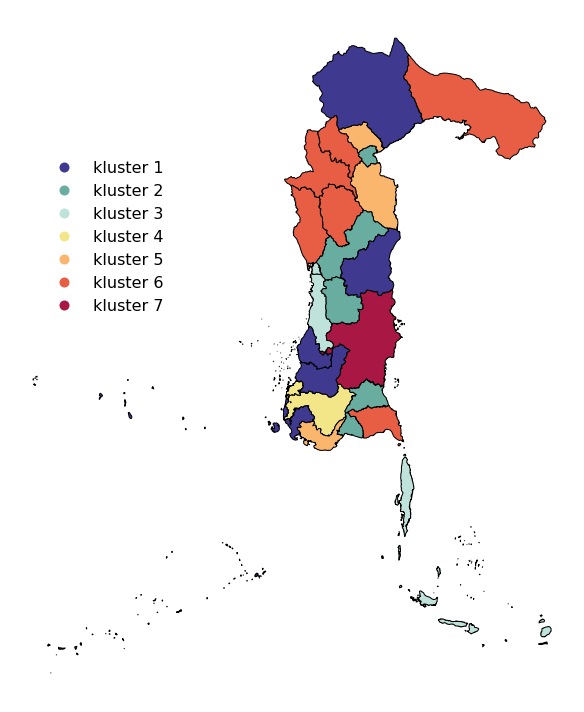

In [88]:
title = ""
fig, ax = plt.subplots(1, figsize=(15,10))
gdf.plot(column='kluster', categorical=True, cmap=new_cmap, linewidth=1, edgecolor='0',
         legend=True, legend_kwds={'bbox_to_anchor':(0.3, 0.8),'fontsize':16,'frameon':False}, ax=ax)
ax.axis('off')
ax.set_title(title,fontsize=20)
plt.tight_layout()
plt.savefig('{}.png'.format(title),dpi=300)

# PFCM

In [89]:
np.random.seed(42)
def calculate_centers(data, U, Upos, m, N, a, b):
    np.random.seed(42)
    um = (U ** m) * a
    uposn = (Upos ** N) * b
    ufull = um + uposn
    #ufull = np.fmax(ufull, np.finfo(np.float64).eps)
    centers = np.dot(ufull.T, data) / np.sum(ufull, axis=0, keepdims=True).T
    #centers = np.fmax(centers, np.finfo(np.float64).eps)
    return centers

def update_membership(data, centers, U, m, N, b, K):
    np.random.seed(42)
    distance_matrix = np.linalg.norm(data[:, np.newaxis] - centers, axis=2) 
    distance_matrix = np.fmax(distance_matrix, np.finfo(np.float64).eps)
    print("\nmatriks jarak")
    print(np.linalg.norm(data[:, np.newaxis] - centers, axis=2))

    gamma = np.diag(np.dot((U ** m).T, distance_matrix))
    gamma = K*(gamma/np.sum(U, axis=0, keepdims=True))
    print("\nparameter scaling")
    print(gamma)

    upos_new = b*(distance_matrix ** 2)/gamma
    upos_new = 1 + (upos_new ** (1/(N-1)) )
    upos_new = 1 / upos_new   
    
    um = distance_matrix ** (2/(m-1))
    um = 1.0 / um
    um = np.fmax(um, np.finfo(np.float64).eps)
    
    
    u_new = um / np.sum(um, axis=1, keepdims=True)
    u_new = np.fmax(u_new, np.finfo(np.float64).eps)
    return u_new, upos_new

def possibilistic_fuzzy_c_means(data, n_clusters, m, N, a, b, K, max_iters, tol):
    n_samples, n_features = data.shape

    # Inisialisasi nilai keanggotaan fuzzy secara acak
    np.random.seed(42)
    U = np.random.rand(n_samples, n_clusters)
    U /= np.sum(U, axis=1, keepdims=True)
    print("\nMatriks Keanggotaan Fuzzy Awal")
    print(U, "\n")
    
    
    # Inisialisasi matrix keanggotaan possibilistic
    np.random.seed(42)
    Upos = np.random.rand(n_samples, n_clusters)
    print("\n\nMatriks Keanggotaan Possibilistic Awal")
    print(Upos, "\n")

    for iteration in range(max_iters):
        print("\n","*"*20)
        print("Iterasi Ke-",iteration)
        
        # Simpan nilai keanggotaan fuzzy sebelum diperbarui
        U_old = U.copy()

        # Langkah 1: Perbarui pusat klaster
        centers = calculate_centers(data, U, Upos, m, N, a, b)
        print("\nPusat Cluster Iterasi Ke-", iteration)
        print(centers)
        
        # Langkah 2: Perbarui nilai keanggotaan fuzzy
        U, Upos = update_membership(data, centers, U, m, N, b, K)
        print("\nMatriks Keanggotaan Fuzzy Terperbarui pada iterasi Ke-", iteration)
        print(U)
        
        print("\nMatriks Keanggotaan Possibilistic Terperbarui pada iterasi Ke-", iteration)
        print(Upos)

        # Hitung perubahan nilai keanggotaan fuzzy
        diff = np.linalg.norm(U - U_old)
        print("\nNilai U baru - U Sekarang =", diff)
        
        # Cek kriteria konvergensi
        if diff < tol:
            # print("Konvergensi tercapai pada iterasi ke-{}".format(iteration + 1))
            break

    return U, centers

# Aplikasi PFCM pada data yang dianalisis

In [90]:
df = pd.read_csv("data kemiskinan.csv", sep = ";")
df

,ADM2_EN,PPM,IPM,UHH,HLS,RLS,DTKS
0,Bantaeng,9.07,69.69,70.88,12.30,6.81,117414
1,Barru,8.40,71.53,69.35,13.61,8.25,89034
2,Bone,10.58,67.01,67.57,12.99,7.36,597850
3,Bulukumba,7.39,70.34,68.51,13.42,8.01,181002
4,Enrekang,12.39,73.39,71.17,13.86,8.93,162947
5,Gowa,7.36,70.99,70.70,13.66,8.40,404024
6,Jeneponto,13.73,65.13,66.81,12.11,6.75,285279
7,Kepulauan Selayar,12.24,68.35,68.81,12.67,8.09,75526
8,Kota Makassar,4.58,83.12,72.40,15.59,11.55,436869
9,Kota Palopo,7.78,78.91,71.18,15.10,11.09,105371


In [91]:
data = df.iloc[:, 1:]
data = data.values
np.set_printoptions(suppress=True)

# # Membuat objek MinMaxScaler
# scaler = MinMaxScaler()
# # Melakukan normalisasi dengan Min-Max Scaling
# normalized_data = scaler.fit_transform(data)
# normalized_data

# # Z-Score Normalization
# mean = np.mean(data, axis=0)
# std_dev = np.std(data, axis=0)
# normalized_data = (data - mean) / std_dev
# normalized_data

# # Membuat objek StandardScaler
# scaler = StandardScaler()
# # Melakukan standarisasi
# normalized_data = scaler.fit_transform(data)
# normalized_data

### Penentuan Jumlah Kluster Maksimal

In [92]:
list_n_clusters = [2,3,4,5,6,7,8,9,10]
list_a = [1]
list_b = [1]

m = 2
N = 2
K = 1
max_iters = 100
tol = 1e-3

# Membuat DataFrame kosong dengan nama kolom
columns = ['n_cluster', 'calinski_harabasz_avg']
df_posibilistic_fuzzy_c_means = pd.DataFrame(columns=columns)

counter = 0

sys._original_stdout = sys.stdout
sys.stdout = open(os.devnull, 'w')

for n_clusters in list_n_clusters:
    for a in list_a:
        for b in list_b:
            max_iters = 100
            tol = 1e-4

            U, centers = possibilistic_fuzzy_c_means(data, n_clusters, m, N, a, b, K, max_iters, tol)

            class_cluster_list = []
            for i in U:
                class_cluster_list.append(np.argmax(i))

            # Menghitung Silhouette Score
            silhouette_avg = silhouette_score(data, class_cluster_list)
            davies_bouldin_avg = davies_bouldin_score(data, class_cluster_list)
            calinski_harabasz_avg = calinski_harabasz_score(data, class_cluster_list)

            #print("davies_bouldin_score", davies_bouldin_avg)
            #print("Silhouette Score:", silhouette_avg)

            # Menambahkan baris baru dengan list
            new_row = [n_clusters, calinski_harabasz_avg]  # Ganti dengan nilai yang sesuai
            df_posibilistic_fuzzy_c_means.loc[len(df_posibilistic_fuzzy_c_means)] = new_row

            
sys.stdout.close()
sys.stdout = sys._original_stdout


df_posibilistic_fuzzy_c_means

,n_cluster,calinski_harabasz_avg
0,2.0,61.452842
1,3.0,66.483378
2,4.0,78.769601
3,5.0,136.755365
4,6.0,225.042095
5,7.0,306.964097
6,8.0,341.975927
7,9.0,328.442918
8,10.0,282.401463


In [93]:
# Mengurutkan berdasarkan kolom 'kinerja' secara naik
df_sorted = df_posibilistic_fuzzy_c_means.sort_values(by='calinski_harabasz_avg', ascending=False)
df_sorted

,n_cluster,calinski_harabasz_avg
6,8.0,341.975927
7,9.0,328.442918
5,7.0,306.964097
8,10.0,282.401463
4,6.0,225.042095
3,5.0,136.755365
2,4.0,78.769601
1,3.0,66.483378
0,2.0,61.452842


In [94]:
#df_posibilistic_fuzzy_c_means.to_csv("df_posibilistic_fuzzy_c_means_daus.csv", index=False)

# Peta Hasil Clustering PFCM

In [95]:
n_clusters = 8
m = 2
N = 2
a = 2
b = 1
K = 0.01
max_iters = 100
tol = 1e-3

U, centers = possibilistic_fuzzy_c_means(data, n_clusters, m, N, a, b, K, max_iters, tol)


class_cluster_list = []
for i in U:
    class_cluster_list.append(np.argmax(i))

print("\n\n")
print("hasil akhir")
print("*"*30)
print("Nilai keanggotaan fuzzy:")
print(U)
print("Penentuan Kelas")
print(class_cluster_list)
print("Pusat klaster:")
print(centers)

# Menghitung Silhouette Score
silhouette_avg = silhouette_score(data, class_cluster_list)
davies_bouldin_avg = davies_bouldin_score(data, class_cluster_list)
calinski_harabasz_avg = calinski_harabasz_score(data, class_cluster_list)
print("davies_bouldin_score", davies_bouldin_avg)
print("Silhouette Score:", silhouette_avg)
print("calinski_harabasz_avg", calinski_harabasz_avg)


Matriks Keanggotaan Fuzzy Awal
[[0.09622888 0.24426269 0.18806787 0.15381059 0.04008516 0.04007896
  0.01492316 0.22254269]
 [0.16203901 0.19087093 0.00554884 0.26145285 0.22439663 0.057239
  0.04901348 0.04943927]
 [0.10271424 0.17716131 0.14582755 0.09832092 0.20656567 0.04709407
  0.09863001 0.12368623]
 [0.13524854 0.23284562 0.05921369 0.15249733 0.17568182 0.01377497
  0.18016874 0.0505693 ]
 [0.01507695 0.2199224  0.22380372 0.18736157 0.07060008 0.02263738
  0.15858411 0.10201377]
 [0.036825   0.14941946 0.01037672 0.27438712 0.07808677 0.19991587
  0.09405871 0.15693035]
 [0.09376919 0.03170537 0.16629863 0.13294716 0.16113847 0.15347661
  0.10254901 0.15811556]
 [0.03538921 0.0783759  0.01808694 0.1301035  0.15543671 0.10851573
  0.33142207 0.14266994]
 [0.07394668 0.14284672 0.03709362 0.21115171 0.01962298 0.25976521
  0.20326778 0.0523053 ]
 [0.001544   0.22800557 0.19763953 0.20383269 0.2156496  0.02070312
  0.10022814 0.03239735]
 [0.22220953 0.16047067 0.08519106 0.016

[[0.0763982  0.12624101 0.71653816 0.01078764 0.0165844  0.00363265
  0.03652975 0.01328819]
 [0.14505948 0.19543623 0.43112139 0.03499939 0.04933243 0.01385248
  0.08878615 0.04141244]
 [0.09271773 0.08840793 0.08052484 0.13794662 0.12091346 0.24829034
  0.10238678 0.12881231]
 [0.06196578 0.02333433 0.00732074 0.0045027  0.01224114 0.00073746
  0.88283907 0.0070588 ]
 [0.9658403  0.02613233 0.00230501 0.00033173 0.00068522 0.00007263
  0.00416748 0.0004653 ]
 [0.04752793 0.04364231 0.03708154 0.10459591 0.07910903 0.54072942
  0.05708405 0.09022981]
 [0.03787803 0.03209438 0.02378512 0.3024751  0.12335081 0.24306673
  0.0554549  0.18189493]
 [0.15452435 0.19837979 0.37273323 0.04379289 0.05989888 0.01842167
  0.10115999 0.0510892 ]
 [0.06235192 0.05783508 0.05004565 0.12252058 0.09688673 0.428891
  0.07318603 0.10828301]
 [0.11880109 0.17530227 0.55209035 0.02202632 0.0324793  0.00799571
  0.06468904 0.02661591]
 [0.15843751 0.19753078 0.33927158 0.04994871 0.06689879 0.02196183
  0.

[[0.08561787 0.73198361 0.11930046 0.00076953 0.01724985 0.00176284
  0.03685278 0.00646306]
 [0.01615837 0.04540021 0.92048311 0.00034397 0.00525931 0.0007442
  0.009254   0.00235683]
 [0.00019338 0.00016956 0.00013638 0.9973508  0.00025363 0.0013146
  0.00021615 0.0003655 ]
 [0.0642331  0.00957806 0.00215265 0.00013191 0.01661174 0.00035662
  0.90471441 0.00222152]
 [0.99888458 0.00034497 0.00004484 0.00000171 0.00010497 0.00000437
  0.00059209 0.00002247]
 [0.01086716 0.00862525 0.00601806 0.01799813 0.01825888 0.8828961
  0.01334397 0.04199245]
 [0.00114613 0.00074445 0.00040804 0.00018425 0.0037798  0.00081704
  0.00175484 0.99116545]
 [0.00188681 0.00434048 0.99139729 0.00005341 0.00070518 0.00011276
  0.00116722 0.00033685]
 [0.00048106 0.00039198 0.00028349 0.00151017 0.00075388 0.99451001
  0.00057571 0.0014937 ]
 [0.09075179 0.39227162 0.43454942 0.00124689 0.02341951 0.00278513
  0.04542228 0.00955337]
 [0.02093673 0.04298709 0.90741538 0.0007223  0.00856182 0.00149629
  0.0

[[ 44176.58106038  11475.3311042   40127.38052286 480409.42942012
   99093.24745063 303199.07289811  67696.50485549 162807.84948788]
 [ 72556.5810018   39855.33093469  11747.38042732 508789.42942707
  127473.24743367 331579.07283429  96076.50480284 191187.84950524]
 [436259.4191551  468960.66911667 520563.38034364     26.57060201
  381342.75262223 177236.92765593 412739.49522918 317628.15059985]
 [ 19411.41984     52112.66911413 103715.38035553 416821.42942535
   35505.24756547 239611.07289551   4108.505109    99219.84960553]
 [  1356.42160701  34057.66955336  85660.38038384 434876.42946722
   53560.24765305 257666.07287563  22163.50536122 117274.84956745]
 [242433.41913204 275134.66909528 326737.38030948 193799.42949486
  187516.75266958  16589.07408316 218913.49520641 123802.15076976]
 [123688.41946004 156389.66932144 207992.38054284 312544.42942238
   68771.75285295 135334.07366462 100168.4955641    5057.15207537]
 [ 86064.58105787  53363.33112656   1760.6297045  522297.42940451
  1

  0.00000007 0.00000001]]

Nilai U baru - U Sekarang = 0.008191783697582796

 ********************
Iterasi Ke- 23

Pusat Cluster Iterasi Ke- 23
[[    10.77128574     71.74826952     72.34043734     13.55410285
       8.61256246 161468.53886204]
 [     8.04866953     70.44366213     69.91809412     13.13846007
       7.91953743 128273.67376034]
 [     8.83754455     72.87058321     69.92745433     13.61164674
       9.06289416  77113.05394947]
 [    10.57925799     67.01177073     67.5706258      12.99028613
       7.36046089 597823.45777975]
 [    10.77390539     69.79433127     67.98565186     12.77147465
       7.70306389 216493.38816021]
 [     5.95563147     77.11788045     71.55878472     14.6349984
       9.99132852 420612.9332958 ]
 [     8.47582577     71.14246886     69.34048051     13.31535055
       8.0248508  185088.09946113]
 [    13.10944135     68.23988973     68.774265       12.75375389
       7.61349735 280221.7740431 ]]

matriks jarak
[[ 44054.5390219   10859.67396617

Matriks Keanggotaan Fuzzy Terperbarui pada iterasi Ke- 24
[[0.05105415 0.85108849 0.0609061  0.00042904 0.01008698 0.00107712
  0.02162246 0.00373567]
 [0.02363804 0.08081639 0.869479   0.0004789  0.00763111 0.00112759
  0.01343738 0.00339159]
 [0.         0.         0.         0.99999995 0.         0.00000002
  0.         0.00000001]
 [0.04091861 0.00560848 0.00144823 0.00009    0.01241427 0.00027235
  0.93765971 0.00158835]
 [0.99237336 0.00183306 0.00030025 0.0000117  0.0007719  0.00003333
  0.00451547 0.00016091]
 [0.00445542 0.00344589 0.00245275 0.00698006 0.00745444 0.95263792
  0.00546916 0.01710437]
 [0.00164679 0.00102334 0.00058258 0.00025848 0.00533639 0.00137861
  0.00251523 0.98725857]
 [0.00033212 0.00088382 0.99836826 0.00000899 0.0001234  0.00002059
  0.0002043  0.00005853]
 [0.00335344 0.00266982 0.00196518 0.00981886 0.00523764 0.96257633
  0.00401248 0.01036625]
 [0.08427793 0.50861137 0.3314975  0.00109306 0.02146722 0.00266737
  0.04171522 0.00867033]
 [0.01576332

Nilai U baru - U Sekarang = 0.0037750492328198636

 ********************
Iterasi Ke- 28

Pusat Cluster Iterasi Ke- 28
[[    10.76295399     71.74287882     72.33635916     13.55316911
       8.6101807  161411.96534392]
 [     8.06128752     70.47706063     69.93845304     13.1398385
       7.92400402 127997.00470078]
 [     8.83895624     72.86594949     69.92694439     13.60982704
       9.06212444  77039.13432072]
 [    10.57925802     67.0117704      67.57062567     12.99028608
       7.3604608  597823.46918294]
 [    10.77252687     69.79410452     67.98553184     12.77152657
       7.70294554 216489.59341069]
 [     5.95563781     77.11785159     71.55878051     14.63499382
       9.99132101 420612.87757378]
 [     8.47480383     71.1426577      69.3405002      13.31530606
       8.02500345 185078.83024154]
 [    13.10944017     68.23988914     68.7742638      12.75375381
       7.61349721 280221.76678713]]

matriks jarak
[[ 43997.96550316  10583.00491196  40374.86590016 480409.46

  0.1105724  0.01128847]]

Matriks Keanggotaan Possibilistic Terperbarui pada iterasi Ke- 33
[[0.00000002 0.00000069 0.00000005 0.         0.00000001 0.
  0.00000001 0.        ]
 [0.00000001 0.00000005 0.00000052 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.00073636 0.         0.
  0.         0.        ]
 [0.00000008 0.00000003 0.00000001 0.         0.00000005 0.
  0.00000212 0.        ]
 [0.00001251 0.00000006 0.00000001 0.         0.00000002 0.
  0.00000007 0.        ]
 [0.         0.         0.         0.         0.         0.00000057
  0.         0.        ]
 [0.         0.         0.         0.         0.00000001 0.00000001
  0.         0.00000185]
 [0.         0.00000003 0.00003441 0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.00000059
  0.         0.        ]
 [0.00000001 0.00000015 0.00000009 0.         0.00000001 0.
  0.00000001 0.        ]
 [0.         0.00000002 0.0000004

       7.6134971  280221.75654084]]
davies_bouldin_score 0.32264545556465385
Silhouette Score: 0.5776869368559493
calinski_harabasz_avg 341.97592670152267


In [96]:
df['kluster'] = class_cluster_list
for i in range(n_clusters):
    df['kluster'].replace(i, "kluster {}".format(i+1), inplace=True)
df

,ADM2_EN,PPM,IPM,UHH,HLS,RLS,DTKS,kluster
0,Bantaeng,9.07,69.69,70.88,12.30,6.81,117414,kluster 2
1,Barru,8.40,71.53,69.35,13.61,8.25,89034,kluster 3
2,Bone,10.58,67.01,67.57,12.99,7.36,597850,kluster 4
3,Bulukumba,7.39,70.34,68.51,13.42,8.01,181002,kluster 7
4,Enrekang,12.39,73.39,71.17,13.86,8.93,162947,kluster 1
5,Gowa,7.36,70.99,70.70,13.66,8.40,404024,kluster 6
6,Jeneponto,13.73,65.13,66.81,12.11,6.75,285279,kluster 8
7,Kepulauan Selayar,12.24,68.35,68.81,12.67,8.09,75526,kluster 3
8,Kota Makassar,4.58,83.12,72.40,15.59,11.55,436869,kluster 6
9,Kota Palopo,7.78,78.91,71.18,15.10,11.09,105371,kluster 2


In [97]:
gdf = gpd.read_file('peta_sulsel\idn_admbnda_adm2_bps_20200401.shp')
gdf.drop(columns=['ADM2_PCODE','ADM2_REF', 'ADM2ALT1EN',
                 'ADM2ALT2EN', 'ADM1_PCODE', 'ADM0_EN',
                 'ADM0_PCODE', 'date', 'validOn', 'validTo'], inplace=True)
gdf = gdf.loc[(gdf['ADM1_EN'] == 'Sulawesi Selatan')].reset_index(drop=True)
gdf['kluster'] = df['kluster']
gdf.head()

,Shape_Leng,Shape_Area,ADM2_EN,ADM1_EN,geometry,kluster
0,1.009615,0.032547,Bantaeng,Sulawesi Selatan,"POLYGON ((119.94123 -5.35478, 119.94185 -5.354...",kluster 2
1,2.404726,0.096852,Barru,Sulawesi Selatan,"MULTIPOLYGON (((119.57194 -4.48674, 119.57201 ...",kluster 3
2,4.806983,0.374794,Bone,Sulawesi Selatan,"MULTIPOLYGON (((120.31470 -4.95371, 120.31444 ...",kluster 4
3,2.050164,0.095123,Bulukumba,Sulawesi Selatan,"MULTIPOLYGON (((120.47836 -5.67575, 120.47854 ...",kluster 7
4,2.080281,0.148512,Enrekang,Sulawesi Selatan,"POLYGON ((119.78261 -3.24008, 119.78384 -3.240...",kluster 1


In [98]:
def inter_from_256(x):
    return np.interp(x=x,xp=[0,255],fp=[0,1])


cdict = {
    'red':((0.0,inter_from_256(64),inter_from_256(64)),
           (1/6*1,inter_from_256(112),inter_from_256(112)),
           (1/6*2,inter_from_256(230),inter_from_256(230)),
           (1/6*3,inter_from_256(253),inter_from_256(253)),
           (1/6*4,inter_from_256(244),inter_from_256(244)),
           (1/6*5,inter_from_256(0),inter_from_256(0)),
           (1.0,inter_from_256(255),inter_from_256(255))),
    'green': ((0.0, inter_from_256(57), inter_from_256(57)),
            (1 / 6 * 1, inter_from_256(198), inter_from_256(198)),
            (1 / 6 * 2, inter_from_256(241), inter_from_256(241)),
            (1 / 6 * 3, inter_from_256(219), inter_from_256(219)),
            (1 / 6 * 4, inter_from_256(109), inter_from_256(109)),
            (1 / 6 * 5, inter_from_256(23), inter_from_256(23)),
            (1.0, inter_from_256(255),inter_from_256(255))),
    'blue': ((0.0, inter_from_256(144), inter_from_256(144)),
              (1 / 6 * 1, inter_from_256(162), inter_from_256(162)),
              (1 / 6 * 2, inter_from_256(246), inter_from_256(146)),
              (1 / 6 * 3, inter_from_256(127), inter_from_256(127)),
              (1 / 6 * 4, inter_from_256(69), inter_from_256(69)),
              (1 / 6 * 5, inter_from_256(69), inter_from_256(69)),
              (1.0,inter_from_256(0),inter_from_256(0))),
}

new_cmap2 = colors.LinearSegmentedColormap('new_cmap',segmentdata=cdict)

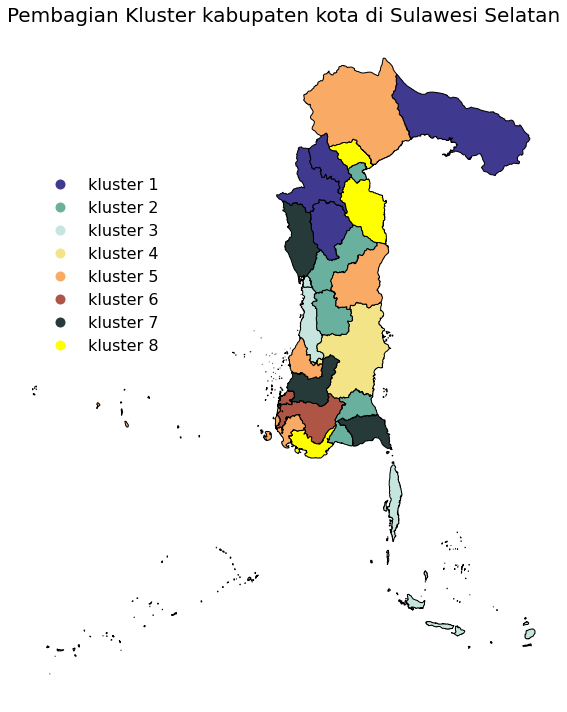

In [99]:
title = "Pembagian Kluster kabupaten kota di Sulawesi Selatan"
fig, ax = plt.subplots(1, figsize=(15,10))
gdf.plot(column='kluster', categorical=True, cmap=new_cmap2, linewidth=1, edgecolor='0',
         legend=True, legend_kwds={'bbox_to_anchor':(0.3, 0.8),'fontsize':16,'frameon':False}, ax=ax)
ax.axis('off')
ax.set_title(title,fontsize=20)
plt.tight_layout()
plt.savefig('{}.png'.format(title),dpi=300)